# Deblender Model

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def query_nist(spectra, low_w, upp_w):
    """
    Build the query URL with fixed parameters and custom spectra, low_w, upp_w.
    """
    base_url = "https://physics.nist.gov/cgi-bin/ASD/lines1.pl"
    params = {
        "spectra": spectra,        # e.g., "Ar" or "Hg"
        "output_type": "0",
        "low_w": str(low_w),
        "upp_w": str(upp_w),
        "unit": "1",
        "submit": "Retrieve Data",
        "de": "0",
        "plot_out": "0",
        "I_scale_type": "1",
        "format": "0",
        "line_out": "0",
        "en_unit": "0",
        "output": "0",
        "bibrefs": "1",
        "page_size": "15",
        "show_obs_wl": "1",
        "unc_out": "1",
        "order_out": "0",
        "max_low_enrg": "",
        "show_av": "2",
        "max_upp_enrg": "",
        "tsb_value": "0",
        "min_str": "",
        "A_out": "0",
        "intens_out": "on",
        "max_str": "",
        "allowed_out": "1",
        "forbid_out": "1",
        "min_accur": "",
        "min_intens": "1000",
        "conf_out": "on"
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.text

def parse_nist_html(html):
    """
    Parse the HTML response from NIST and build a DataFrame with the columns:
    Ion, Observed, Unc, Intensity, Aki, Acc, Type, TP Ref, Line Ref.
    """
    soup = BeautifulSoup(html, "html.parser")
    
    # Locate the results table by looking for a table that contains a header with "Ion"
    table = None
    for t in soup.find_all("table"):
        if t.find("th") and "Ion" in t.get_text():
            table = t
            break
    if table is None:
        print("No results table found in the HTML response.")
        return [None]

    # Extract header row texts
    header_row = table.find("tr")
    headers = [th.get_text(strip=True) for th in header_row.find_all("th")]
    # print("Extracted headers:", headers)
    
    # Expected column names
    expected_headers = ["Ion", "Observed", "Unc", "Intensity", "Aki", "Acc", "Lower Level Conf.", " Upper Level Conf.", "Type", "TP Ref", "Line Ref"]

    # Extract data rows
    rows = []
    for row in table.find_all("tr")[2:]:
        cols = row.find_all("td")
        if not cols:
            continue
        # Get text from each column cell
        row_data = [col.get_text(strip=True) for col in cols]
        if row_data:
            rows.append(row_data)
    
    # Build a DataFrame assuming the order of table columns corresponds to expected order
    try:
        df = pd.DataFrame(rows, columns=headers)
    except Exception as e:
        print("Error building DataFrame:", e)
        return [None]

    # If the headers from the table differ from our expected headers, force the expected names.
    # (This assumes the order is correct.)
    if list(df.columns) != expected_headers:
        # print("Warning: Table headers differ from expected. Overriding with expected column names.")
        if len(df.columns)!= len(expected_headers):
            expected_headers.remove("Unc")
        df.columns = expected_headers

    return df


## Class

In [2]:
# from matplotlib import pyplot as plt
# from scipy.signal import savgol_filter
# from lmfit.models import SplineModel, GaussianModel
# from scipy.optimize import fminbound
# import numpy as np
# # from lmfit

# def gaussian(x, mu, A, sigma):
#     """Single Gaussian function."""
#     return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# def sum_gaussians(x, means, amplitudes, sigma):
#     """Sum of multiple Gaussians."""
#     return sum(gaussian(x, mu, A, sigma) for mu, A in zip(means, amplitudes))

# def find_max_gaussians(means, amplitudes, sigma):
#     """Find the approximate max position and value of the sum Gaussians."""
#     weights = [A * np.exp(-((mu - np.mean(means)) ** 2) / (2 * sigma ** 2)) for A, mu in zip(amplitudes, means)]
#     #x_approx = sum(w * mu for w, mu in zip(weights, means)) / sum(weights)

#     # Refine numerically in the range [min(mu) - 2σ, max(mu) + 2σ]
#     x_opt = fminbound(lambda x: -sum_gaussians(x, means, amplitudes, sigma),
#                       np.min(means) - 3 * sigma, np.max(means) + 3 * sigma)
#     return x_opt, sum_gaussians(x_opt, means, amplitudes, sigma)

# class deblendModel:
#     """
#     Model to deblend spectral lines of the Hg/Ar lamp.
#     """
#     def __init__(self, pixel, counts, centers, calibration=[1.,1.], weights=None):
#         if weights is None:
#             weights = [1.0] * len(centers)
    
#         # wavelength pixel relation
#         self.wav2pixel = np.poly1d(calibration)
#         self.x = pixel
#         self.counts = counts

#         self.centers = centers
#         self.weights = weights

#         # centers pixels 
#         self.centers_pixel = self.wav2pixel(centers)
        
#         # Number of Gaussians
#         self.ncomponents = len(centers)

#         # Spectrum resolution
#         self.sigma_nm = 1.3
#         self.sigma_pixel = self.wav2pixel(self.centers[0] + self.sigma_nm) - self.wav2pixel(self.centers[0])

#         # Initial guess for the peak center
#         self.peak_center = self.centers_pixel[0]

#         # Varying parameters
#         self.vary_sigma = True
#         self.vary_delta = True
#         self.vary_weight = True
#         self.free_blend_amplitude = False
#         pass

#     def pixel_center_guess(self, length=3, polyorder=2):
#         """
#         Finds the pixel center of the peak using the maximum 
#         of the sum of the Gaussians in wavelength space.

#         Use the distance from the peak center to the other peaks
#         to estimate the pixel centers of the other peaks.

#         Advatange: The pixel centers are less sensitive to the 
#         wavelength calibration.
#         """
#         x_smooth = np.linspace(self.x.min(), self.x.max(), 10000)
#         y_smooth = np.interp(x_smooth, self.x,savgol_filter(self.counts, length, polyorder))

#         self.peak_center = x_smooth[np.argmax(y_smooth)]
#         self.peak_height = np.max(y_smooth)

#         x_max_3, f_max_3 = find_max_gaussians(self.centers, self.weights, self.sigma_nm)
#         self.peak_guess = x_max_3
#         self.normalization = f_max_3/self.peak_height

#         deltas_nm = self.centers - x_max_3
#         deltas_pixel = self.wav2pixel(self.centers+deltas_nm) - self.wav2pixel(self.centers)
#         self.centers_pixel_guess = self.peak_center+deltas_pixel


#     def fit(self, nsigma=3, nknots=3, npixels=3):
#         # Improve the initial guess
#         self.pixel_center_guess()
#         self.y = self.counts.copy()*self.normalization

#         # Create model and params
#         model, params = self.make_model(nsigma, nknots)

#         # Constrain the parameters
#         params = self.constrain_params(params, npixels)

#         result = model.fit(self.y, params, x=self.x)
#         if result.errorbars is False:
#             print("Re-running fit to compute error bars...")
            
#             # Copy best-fit parameters
#             params = result.params.copy()
            
#             # Re-run the fit explicitly requesting covariance computation
#             result = model.fit(self.y, params, x=self.x, calc_covar=True)

#         self.result = result
#         pass

#     def constrain_params(self, params, npixels=3.0):
#         # Make sure the Gaussian parameters are within reasonable bounds
#         params['peak_center'].min = self.centers_pixel[0]-npixels
#         params['peak_center'].max = self.centers_pixel[0]+npixels
#         params['peak_amplitude'].min = self.weights[0]*0.1
#         params['peak_amplitude'].max = self.weights[0]*10.0
#         params['peak_sigma'].vary = self.vary_sigma
#         params['peak_sigma'].min = self.sigma_pixel/5.
#         params['peak_sigma'].max = 2*self.sigma_pixel

#         # Constrain the blend parameters
#         for i in range(1,self.ncomponents):            
#             params['blend%i_center'%i].expr = 'peak_center + delta%i'%i
#             params['blend%i_sigma'%i].expr = 'peak_sigma'

#             # Add aditional constraints
#             delta = self.centers_pixel[i] - self.centers_pixel[0]
#             weight = self.weights[i] / self.weights[0]

#             params.add('delta%i'%i, value=delta, vary=self.vary_delta)
#             if self.vary_delta:
#                 params['delta%i'%i].min = delta - npixels/2.
#                 params['delta%i'%i].max = delta + npixels/2.

#             if self.free_blend_amplitude:
#                 params['blend%i_amplitude'%i].min = weight/5.
#                 params['blend%i_amplitude'%i].max = weight*5.

#             else:
#                 params['blend%i_amplitude'%i].expr = 'peak_amplitude * weight%i'%i
#                 params.add('weight%i'%i, value=weight, vary=self.vary_weight)
#                 if self.vary_weight:
#                     params['weight%i'%i].min = weight/2.0
#                     params['weight%i'%i].max = weight*2.0
            
#         return params

#     def make_model(self, nsigma=3, nknots=3):
#         # Create the model
#         model = GaussianModel(prefix='peak_')

#         for i in range(1,self.ncomponents):
#             model += GaussianModel(prefix=f'blend{i}_')

#         # Create the parameters
#         params = model.make_params(
#             peak_amplitude=self.weights[0],
#             peak_center=self.centers_pixel[0],
#             peak_sigma=self.sigma_pixel,
#         )
#         # Set initial parameter values
#         for i in range(1, self.ncomponents):
#             # Initialize each blend using the corresponding center and weight
#             params.add(f'blend{i}_amplitude', value=self.weights[i])
#             params.add(f'blend{i}_center', value=self.centers_pixel[i])
#             params.add(f'blend{i}_sigma', value=self.sigma_pixel)
        
#         model, params = self.make_bkg_model(model, params, nsigma, nknots)
#         return model, params

#     def make_bkg_model(self, model, params, nsigma=3, nknots=3):
#         # get the knots
#         left = np.linspace(self.x.min(), np.min(self.centers_pixel) - nsigma * self.sigma_pixel, nknots)
#         right = np.linspace(np.max(self.centers_pixel) + nsigma * self.sigma_pixel, self.x.max(), nknots)
#         knot_xvals = np.append(left, right)

#         if self.ncomponents>2:
#             deltas = np.diff(self.centers_pixel)
#             w = np.where(np.abs(deltas)>2*self.sigma_pixel)[0]
#             # middle = (self.centers_pixel[w+1] + self.centers_pixel[w])/2
#             # knot_xvals = np.sort(np.append(knot_xvals, middle))
#             # print(knot_xvals)

#         self.xknots = knot_xvals
#         # Create Spline Model
#         bkg = SplineModel(prefix='bkg_', xknots=knot_xvals, polyorder=1)
#         model+=bkg

#         # Create the spline model   
#         params = params.update(bkg.guess(self.y, self.x))  # This correctly initializes the spline
#         for bname in params.keys():
#             if "bkg_s" in bname:
#                 i = int(bname[-1])
#                 params[bname].max = 1.05*np.interp(knot_xvals[i], self.x, self.y)
#                 params[bname].min = 0.0
                
#         return model, params
    
#     def plot_fit(self, result=None):
#         if result is None:
#             result = self.result
#         y = self.y
#         x = self.x
#         knot_xvals = self.xknots
#         m1 = self.centers_pixel[0]
        
#         plt.figure(figsize=(6,5))
#         # Plot the fit
#         comps = result.eval_components()
#         plt.plot(x, y, 'ro', label='Data')
#         plt.axvline(m1, color='r', label='P(wav=%.3f)'%self.centers[0])

#         plt.plot(x, result.best_fit,'k', label='Blended Model\n'+ r'$R^2$ = %.5f'%result.rsquared)

#         plt.plot(x, comps['peak_'], color='firebrick', ls='--',label='Ar Ref. Line')
#         plt.axvline(result.params['peak_center'].value, color='firebrick', ls='--')

#         for i in range(1,self.ncomponents):
#             label = 'Blended Line %i'%i
#             plt.plot(x, comps['blend%i_'%i], color='grey', ls='--',label=label)
#             plt.axvline(result.params['blend%i_center'%i].value, color='grey', ls='--')

#         plt.plot(x, comps['bkg_'], color='lightgrey', ls='--', label='Bkg')
#         plt.plot(knot_xvals, np.interp(knot_xvals, x, comps['bkg_']), 'x', color='k')
#         plt.legend()


In [3]:
import sys
sys.path.append('/Users/esteves/Documents/github/PANDORA')
from pandora.calibration.monochromator_calib import Hg2LampLineCharacterization
from pandora.calibration.deblend_model import deblendModel
from pandora.calibration.hg2_lamp import hg2_lines_all as hg2_lines

In [4]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

## Hg02 Hg03

In [60]:
name = 'Hg03'
pHg02 = 152
pHg03 = 163
pX = 152-14
exptime = 9

hg0203 = Hg2LampLineCharacterization(name, pHg03, exptime, window=12)

hg0203.ilow = int(max(pHg03 - hg0203.window-12, 0))
hg0203.ihigh = int(min(pHg03 + hg0203.window, len(hg0203.wav_all)))

hg0203.wav = hg0203.wav_all[hg0203.ilow:hg0203.ihigh]
hg0203.pixel = hg0203.pixel_all[hg0203.ilow:hg0203.ihigh]
hg0203.counts = hg0203.counts_all[hg0203.ilow:hg0203.ihigh]

hg0203.measure_centroids()
# gc, gcerr = hg0203.gaussian_fit()
# hg0203.fit_models()
sigma = 3.16
print(r'$\sigma$: %.3f nm'%sigma)

# hg0203.save_results()

Dark subtraction
Flat fielding
$\sigma$: 3.160 nm


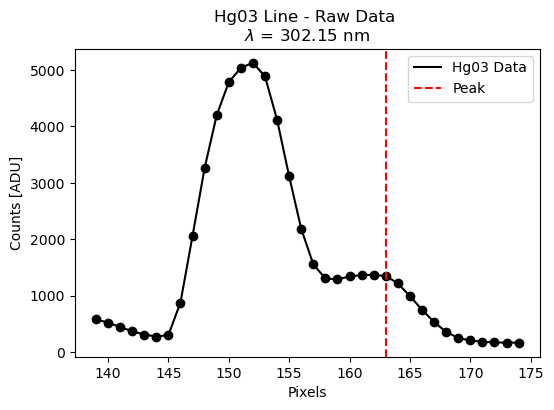

In [105]:
pixel_centers = [pHg02+2, pHg03+2.]
# pixel_centers = [pHg02, pHg03, pHg02-1]
pixel2wav = interp1d(hg0203.pixel_all, hg0203.wav_all)
wav_centers = pixel2wav(pixel_centers)

fig = hg0203.plot_raw_line()

In [106]:
intensitites = np.array([hg0203.peak_height, 1250])
# intensitites = np.array([hg0203.peak_height, 1250, 1500])
# intensitites = np.array([hg0203.peak_height, 15000, 10, 10, 2000])
weights = intensitites/np.sum(intensitites)
popt = np.polyfit(hg0203.wav_all, hg0203.pixel_all, 4)
weights

array([0.80409174, 0.19590826])

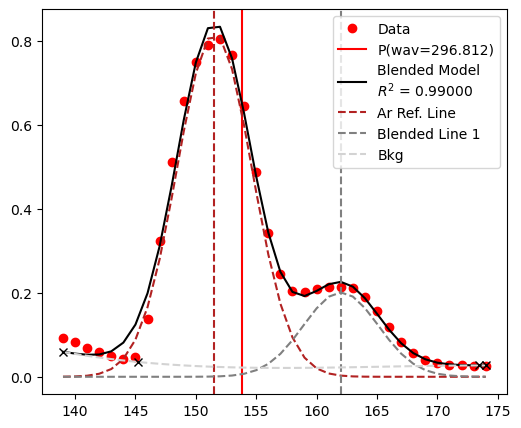

In [110]:
from scipy.signal import savgol_filter
# db = deblendModel(hg0203.pixel, savgol_filter(hg0203.counts,11,3), wav_centers, calibration=popt, weights=weights)
db = deblendModel(hg0203.pixel, hg0203.counts, wav_centers, calibration=popt, weights=weights)
db.vary_sigma = True
db.vary_delta = True
db.free_blend_amplitude = False

db.fit(nsigma=3.5, nknots=2, npixels=3)
db.plot_fit()

In [111]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(151.54317434908376, 0.08638529564389656)

In [112]:
(db.result.params['blend1_center'].value, db.result.params['blend1_center'].stderr)

(162.00828078425658, 0.35104660795006176)

## Ar09 Ar10

In [185]:
peak = 1230.0
exptime = 42
ar0910 = Hg2LampLineCharacterization("Ar10", peak, exptime, window=17)

pAr09 = 1215.0
ar0910.ilow = int(max(pAr09 - ar0910.window, 0))
ar0910.ihigh = int(min(ar0910.peak + ar0910.window+0.5, len(ar0910.wav_all)))

ar0910.wav = ar0910.wav_all[ar0910.ilow:ar0910.ihigh]
ar0910.pixel = ar0910.pixel_all[ar0910.ilow:ar0910.ihigh]
ar0910.counts = ar0910.counts_all[ar0910.ilow:ar0910.ihigh]

ar0910.measure_centroids()
gc, gcerr = ar0910.gaussian_fit()
sigma = 3.16
print(r'$\sigma$: %.3f nm'%sigma)

Dark subtraction
Flat fielding
$\sigma$: 3.160 nm


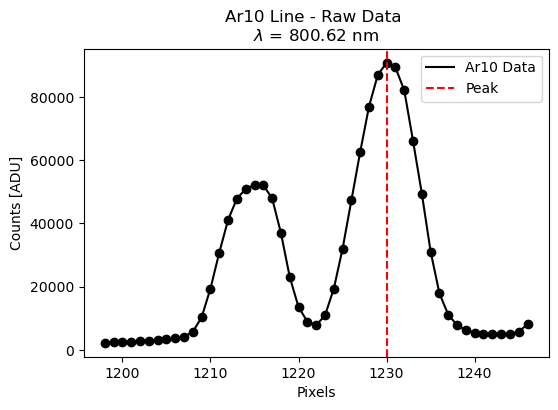

In [186]:
fig = ar0910.plot_raw_line()

In [187]:
std =1.4
Hg04 = 800.616
llow = Hg04-5*std/2.
lupp = Hg04+5*std/2.

thtml = query_nist("Ar", llow, lupp)
ar10df = parse_nist_html(thtml)
ar10df

,Ion,Observed,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,800.6157,20000,4.9e+06,C+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634
1,Ar I,801.4786,25000,9.3e+06,B,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


In [188]:

# pixel_centers = [1228.83972, 1230.94299, 1214.75717]
# pixel2wav = interp1d(ar10.pixel_all, ar10.wav_all)
# wav_centers = pixel2wav(pixel_centers)

In [204]:
wav_centers = np.array([800.616, 801.6958145 , 794.81760])
# intensitites = np.array([ar0910.peak_height*20/45, ar0910.peak_height*25/45, 50e3])
intensitites = np.array([18824.5125, 20108.8491, 20490.9238])
weights = intensitites/np.sum(intensitites)
weights

array([0.31678147, 0.33839446, 0.34482407])

Re-running fit to compute error bars...


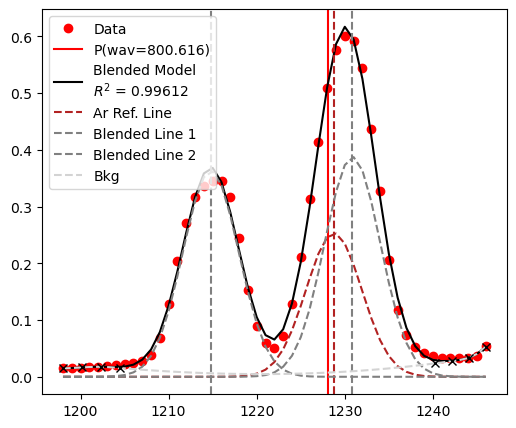

In [226]:
db = deblendModel(ar0910.pixel, ar0910.counts, wav_centers, calibration=popt, weights=weights)
db.vary_sigma = False
db.fit(nsigma=3., nknots=4)
db.plot_fit()

In [227]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(1228.76690282229, 1.4608494294105234)

In [228]:
(db.result.params['blend2_center'].value, db.result.params['blend2_center'].stderr)

(1214.7855974721474, 0.09831237494907223)

## Hg09 

In [62]:
name = 'Hg09'
peak = 651.0
exptime = 12
hg09 = Hg2LampLineCharacterization(name, peak, exptime, window=23)
hg09.measure_centroids()
popt = np.polyfit(hg09.wav_all, hg09.pixel_all, 4)

Dark subtraction
Flat fielding


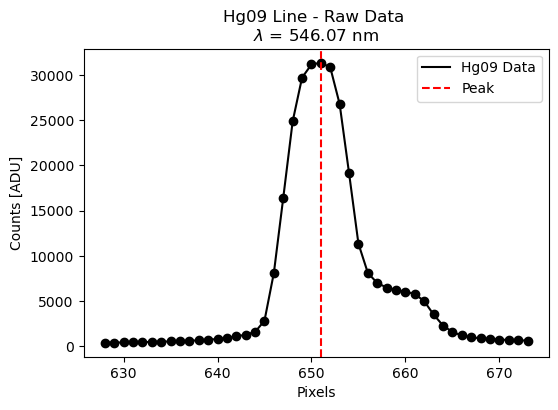

In [63]:
fig = hg09.plot_raw_line()

In [64]:
std =1.4
Hg04 = 546.07350
llow = Hg04-5*std/2.
lupp = Hg04+5*std/2.

thtml = query_nist("Hg", llow, lupp)
ar11df = parse_nist_html(thtml)
ar11df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg I,546.0750,0.0001,6000,4.9e+07,B,5d106s6p,5d106s7s,,T5292,L7247


In [65]:
wav_centers = np.array([546.07350, 550.30411373925])
weight0 = np.array([6, 1])
weights = weight0/np.sum(weight0)


Re-running fit to compute error bars...


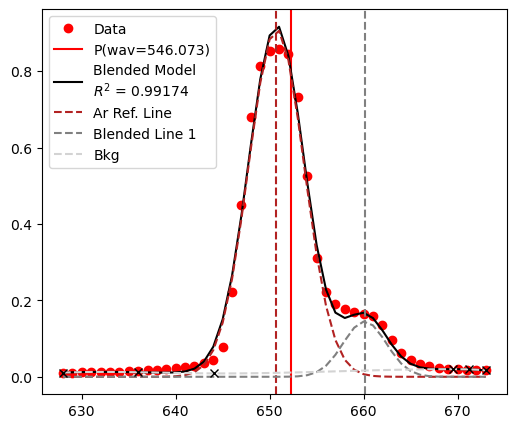

In [66]:
db = deblendModel(hg09.pixel, hg09.counts, wav_centers, calibration=popt, weights=weights)
# db.vary_sigma = True
db.free_vary_sigma = True
db.free_blend_amplitude = True
# db.vary_delta = True
# db.vary_weight = False
db.fit(nsigma=3, nknots=3, npixels=4)
db.plot_fit()

In [67]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(650.7172694517442, None)

In [68]:
(db.result.params['blend1_center'].value, db.result.params['peak_center'].stderr)

(660.1199860213603, None)

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian1D, Polynomial1D
from astropy.modeling.fitting import LevMarLSQFitter

def fit_and_plot_two_gaussians_plus_continuum(
    x, y,
    # Gaussian #1 initial guesses
    amp1, mean1, stddev1,
    # Gaussian #2 initial guesses
    amp2, mean2, stddev2,
    # Polynomial (continuum) initial guesses
    poly_degree=1,
    poly_init_vals=None
):
    """
    Fit two Gaussian lines + a polynomial continuum to (x, y) data using Astropy,
    then plot the result.

    Parameters
    ----------
    x : array-like
        Independent variable (e.g. pixel or wavelength).
    y : array-like
        Measured intensities (counts).
    amp1, mean1, stddev1 : float
        Initial guesses for amplitude, center, and stddev of the 1st Gaussian.
    amp2, mean2, stddev2 : float
        Initial guesses for amplitude, center, and stddev of the 2nd Gaussian.
    poly_degree : int, optional
        Degree of the polynomial continuum. Default is 1 (linear).
    poly_init_vals : list, optional
        Initial values for the polynomial coefficients [c0, c1, ...].
        If None, will default to zeros (except c0 might be near the min(y)).
    """

    # 1) Define two Gaussian models from initial guesses
    g1 = Gaussian1D(amplitude=amp1, mean=mean1, stddev=stddev1)
    g2 = Gaussian1D(amplitude=amp2, mean=mean2, stddev=stddev2)

    # 2) Define a polynomial model for the continuum
    #    If the user hasn't given initial guesses, let's pick something simple
    if poly_init_vals is None:
        # For a linear continuum (degree=1), we can do something like:
        # c0 ~ median(y), c1 ~ small slope
        # For higher degrees, all coefficients can start near 0
        if poly_degree == 1:
            c0_guess = float(np.median(y))  
            c1_guess = 0.0
            poly_init_vals = [c0_guess, c1_guess]
        else:
            poly_init_vals = [0.0]*(poly_degree+1)

    poly_cont = Polynomial1D(degree=poly_degree)
    for i, val in enumerate(poly_init_vals):
        setattr(poly_cont, f'c{i}', val)

    # 3) Combine the Gaussians + continuum
    #    This is now our initial composite model
    model_init = g1 + g2 + poly_cont

    # 4) Perform the fit using Levenberg–Marquardt
    fitter = LevMarLSQFitter()
    best_fit = fitter(model_init, x, y)

    # 5) Print the resulting model parameters
    print("===== Fit Results =====")
    print(best_fit)
    print("=======================")

    # 6) Evaluate on a finer grid for plotting
    x_fine = np.linspace(x.min(), x.max(), 500)
    y_fine = best_fit(x_fine)

    # 7) Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, 'bo', label='Data')
    plt.plot(x_fine, y_fine, 'r-', label='Best Fit')

    # Optional: plot the individual components
    y_g1 = best_fit[0](x_fine)  # the first Gaussian
    y_g2 = best_fit[1](x_fine)  # the second Gaussian
    y_poly = best_fit[2](x_fine)
    plt.plot(x_fine, y_g1, 'g--', label='Gaussian #1')
    plt.plot(x_fine, y_g2, 'm--', label='Gaussian #2')
    plt.plot(x_fine, y_poly, 'k--', label='Continuum')
    plt.axvline(mean1, label=f'guess 1: {mean1:0.2f}',color='k')
    plt.axvline(mean2, label=f'guess 2: {mean2:0.2f}',color='k')

    m1 = best_fit.mean_0.value
    m2 = best_fit.mean_1.value
    plt.axvline(m1, label=f'mean 1: {m1:0.2f}',color='r')
    plt.axvline(m2, label=f'mean 2: {m2:0.2f}',color='r')
    plt.title('Two Gaussian Lines + Polynomial Continuum Fit')
    plt.xlabel('Pixel / Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

===== Fit Results =====
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Gaussian1D(amplitude=31924.51512241, mean=650.76739, stddev=2.97971818)>

    [1]: <Gaussian1D(amplitude=-5046.11016019, mean=669.19801484, stddev=0.)>

    [2]: <Polynomial1D(1, c0=-29972.23787495, c1=48.23376254)>
Parameters:
       amplitude_0           mean_0      ...         c0_2               c1_2      
    ------------------ ----------------- ... ------------------- -----------------
    31924.515122410998 650.7673899957236 ... -29972.237874952556 48.23376253801994


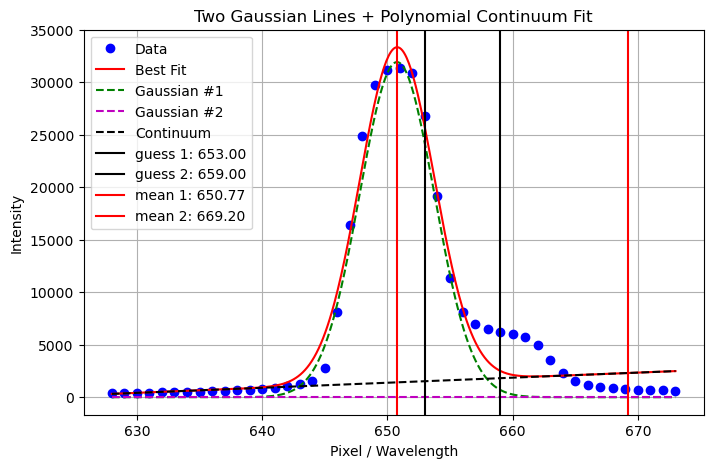

In [70]:
# Example usage:
# cropped_pixel and cropped_counts are your data arrays
fit_and_plot_two_gaussians_plus_continuum(
    hg09.pixel,hg09.counts, hg09.peak_height*weights[0], 653, 3.,
    hg09.peak_height*weights[1], 659, 3,
    poly_degree=1)


## Hg06

In [90]:
name = 'Hg06'
peak = 284.0
exptime = 37
hg06 = Hg2LampLineCharacterization(name, peak, exptime, window=20)

Dark subtraction
Flat fielding


In [91]:
wav_centers = np.array([365.0158, 365.4842, 366.2887, 366.3284])
intensities = np.array([5300,2500,200,200])
weights = intensities/np.sum(intensities)

wav_centers = [wav_centers[0],wav_centers[-1]]
weights = [weights[0], 0.045]

In [93]:
# wav_centers-find_max_gaussians(wav_centers, weights, 3.)[0]

Re-running fit to compute error bars...


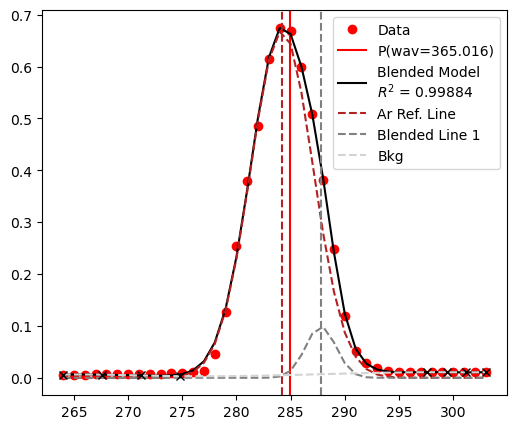

In [99]:
db = deblendModel(hg06.pixel, hg06.counts, wav_centers, calibration=popt, weights=weights)
# db.vary_sigma=False
db.free_vary_sigma = True
db.free_blend_amplitude = True
db.fit(nsigma=4, nknots=4)
db.plot_fit()

In [100]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(284.2017250845611, 0.1806918041297908)

In [101]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(284.2017250845611, 0.1806918041297908)

## Hg07

In [102]:
name = "Hg07"
# 4400,404.6565,24705.339
# 270,407.7837,24515.883

In [130]:
name = "Hg07"
peak = 362.783223
exptime = 47

hg07 = Hg2LampLineCharacterization(name, peak, exptime, window=22)

Dark subtraction
Flat fielding


In [131]:
wav_centers = [404.6565, 407.7837]
intensities = [4400, 1570]
weights = intensities/np.sum(intensities)
weights

array([0.73701843, 0.26298157])

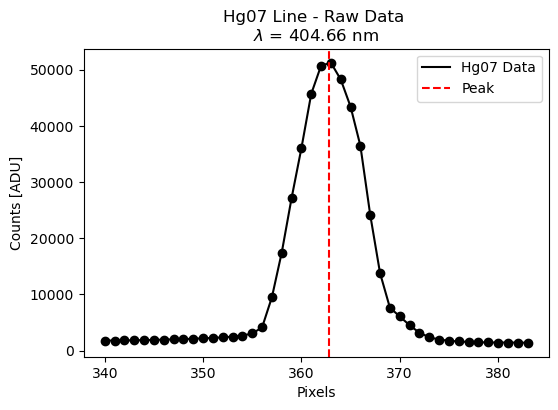

In [132]:
fig = hg07.plot_raw_line()

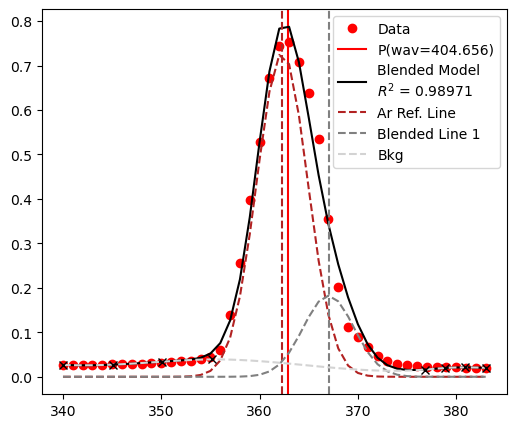

In [136]:
db = deblendModel(hg07.pixel, hg07.counts, wav_centers, calibration=popt, weights=weights)
# db.free_blend_amplitude = True
# db.free_vary_sigma = True
db.vary_sigma = False
db.fit(nsigma=3, nknots=4)
db.plot_fit()

In [137]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(362.3070034915113, 0.16637124141472873)

In [135]:
# db.result

## Ar06

In [1334]:
name = 'Ar06'
peak = 1109.0
exptime = 22
ar06 = Hg2LampLineCharacterization(name, peak, exptime, window=20)
weights = np.array([20000, 15000])
weights = weights/np.sum(weights)
wav_centers = [750.5869, 751.4652]

Dark subtraction
Flat fielding


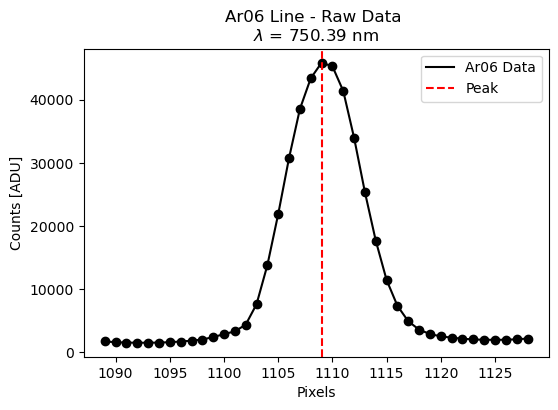

In [1335]:
fig = ar06.plot_raw_line()

Re-running fit to compute error bars...


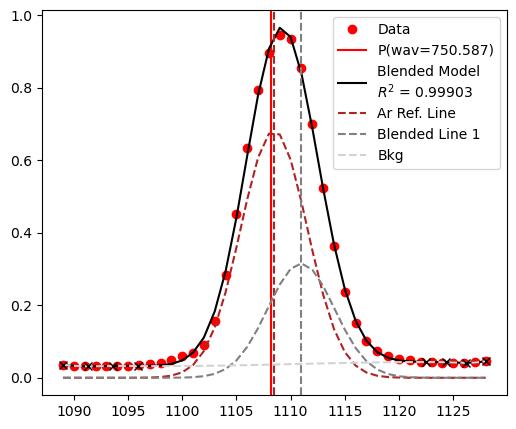

In [1336]:
db = deblendModel(ar06.pixel, ar06.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=4, nknots=4)
db.plot_fit()

In [1337]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(1108.4720517028056, 0.3241801868597605)

## Ar09 Ar10

In [5870]:
peak = 1230.0
exptime = 42
ar0910 = Hg2LampLineCharacterization("Ar10", peak, exptime, window=17)

pAr09 = 1215.0
ar0910.ilow = int(max(pAr09 - ar0910.window, 0))
ar0910.ihigh = int(min(ar0910.peak + ar0910.window, len(ar0910.wav_all)))

ar0910.wav = ar0910.wav_all[ar0910.ilow:ar0910.ihigh]
ar0910.pixel = ar0910.pixel_all[ar0910.ilow:ar0910.ihigh]
ar0910.counts = ar0910.counts_all[ar0910.ilow:ar0910.ihigh]

ar0910.measure_centroids()
gc, gcerr = ar0910.gaussian_fit()
sigma = 3.16
print(r'$\sigma$: %.3f nm'%sigma)

$\sigma$: 3.160 nm


In [5871]:

# pixel_centers = [1228.83972, 1230.94299, 1214.75717]
# pixel2wav = interp1d(ar10.pixel_all, ar10.wav_all)
# wav_centers = pixel2wav(pixel_centers)

In [5872]:
wav_centers = np.array([800.83302109, 801.6958145 , 795.04377832])
intensitites = np.array([16824.5125, 21108.8491, 22490.9238])
weights = intensitites/np.sum(intensitites)
weights

array([0.27843958, 0.34934379, 0.37221663])

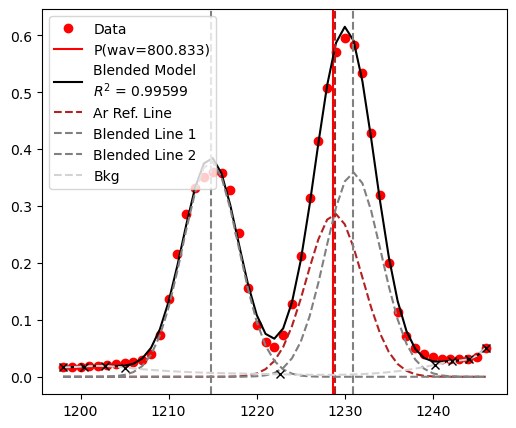

In [5873]:
db = deblendModel(ar0910.pixel, ar0910.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=3., nknots=4)
db.plot_fit()

In [5874]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(1228.8461553333932, 0.06888983435958825)

In [5875]:
(db.result.params['blend2_center'].value, db.result.params['blend2_center'].stderr)

(1214.7651150583583, 0.10227321526524288)

In [5876]:
name = "Ar11"
std =1.4
Hg04 = 811.531
llow = Hg04-5*std/2.
lupp = Hg04+5*std/2.

thtml = query_nist("Ar", llow, lupp)
ar11df = parse_nist_html(thtml)
ar11df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,810.3693,,20000,2.50e+07,B+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634
1,Ar II,810.36931,0.00002,"12023r,bl",,,3s23p4(3P)3d,3s23p4(3P)4p,,,L11520
2,Ar I,811.5311,,35000,3.3e+07,B,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


In [5877]:
wav_centers = [811.5311, 810.3693]
intensities = [35000, 20000]
weights = intensities/np.sum(intensities)
weights

array([0.63636364, 0.36363636])

In [5878]:
name = "Ar11"
peak = 1254.0
exptime = 2

ar11 = Hg2LampLineCharacterization(name, peak, exptime, window=16)

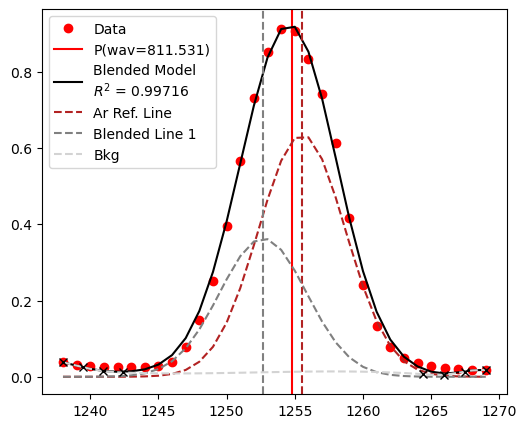

In [5879]:
db = deblendModel(ar11.pixel, ar11.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=3., nknots=4)
db.plot_fit()

In [5880]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(1255.5249503119471, 0.07840408765929084)

## Ar02 Ar03

In [5907]:
pAr01 = 981.68
pAr02 = 1006.0
pAr03 = 1024.0
exptime = 142
ar0203 = Hg2LampLineCharacterization("Ar03", pAr03, exptime, window=11.)

ar0203.ilow = int(max(pAr01 - ar0203.window, 0))
ar0203.ihigh = int(min(ar0203.peak + ar0203.window, len(ar0203.wav_all)))

ar0203.wav = ar0203.wav_all[ar0203.ilow:ar0203.ihigh]
ar0203.pixel = ar0203.pixel_all[ar0203.ilow:ar0203.ihigh]
ar0203.counts = ar0203.counts_all[ar0203.ilow:ar0203.ihigh]

ar0203.measure_centroids()
sigma = 3.16
print(r'$\sigma$: %.3f nm'%sigma)

$\sigma$: 3.160 nm


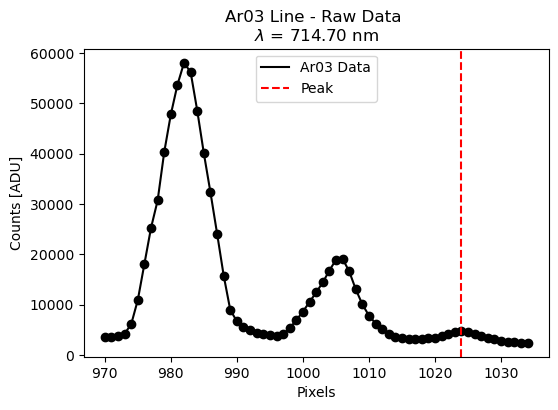

In [5908]:
fig = ar0203.plot_raw_line()

In [5909]:
pixel_centers = [pAr01, pAr02, pAr03]
pixel2wav = interp1d(ar0203.pixel_all, ar0203.wav_all)
wav_centers = pixel2wav(pixel_centers)
wav_centers

array([696.086964, 706.6892  , 714.4948  ])

In [5910]:
intensitites = np.array([38999, 10500, 1235])
weights = intensitites/np.sum(intensitites)
weights

array([0.76869555, 0.2069618 , 0.02434265])

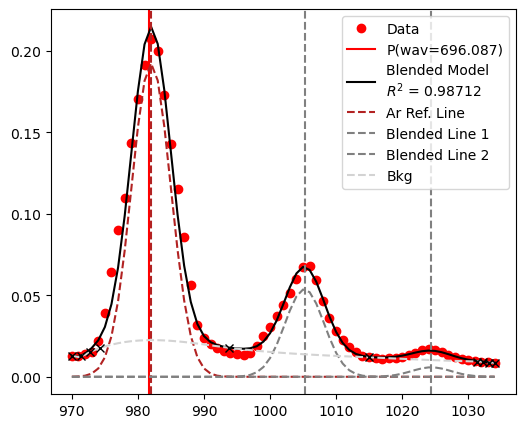

In [5919]:
db = deblendModel(ar0203.pixel, ar0203.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=2.5, nknots=4)
db.plot_fit()

In [5912]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(982.0564012892409, 0.06318741311679134)

In [5913]:
(db.result.params['blend1_center'].value, db.result.params['blend1_center'].stderr)

(1005.1603970782152, 0.17552776262117156)

In [5914]:
(db.result.params['blend2_center'].value, db.result.params['blend2_center'].stderr)

(1024.7467770217, 2.1263172841935196)

In [5915]:
coefs = np.array([-5.27833147e-05,  5.40645454e-01,  2.15899046e+02])
p2w = np.poly1d(coefs)
p2w([981.68715344, 1005.04933128, 1024.40971885])

array([695.77595211, 705.95669667, 714.34988697])

In [5916]:
p2w([db.result.params['peak_center'].value, db.result.params['blend1_center'].value, db.result.params['blend2_center'].value])

array([695.93731068, 706.00495919, 714.4956593 ])

In [5917]:
mylist =[696.54310,706.72180,714.70420]


In [5918]:
[981.68715344, 1005.04933128, 1024.40971885]

[981.68715344, 1005.04933128, 1024.40971885]

In [5893]:
# pAr01 = 981.68
pAr02 = 1004.04933128
pAr03 = 1024.40971
exptime = 142
ar0203 = Hg2LampLineCharacterization("Ar03", pAr03, exptime, window=13.)

ar0203.ilow = int(max(pAr02 - ar0203.window, 0))
ar0203.ihigh = int(min(ar0203.peak + ar0203.window+5, len(ar0203.wav_all)))

ar0203.wav = ar0203.wav_all[ar0203.ilow:ar0203.ihigh]
ar0203.pixel = ar0203.pixel_all[ar0203.ilow:ar0203.ihigh]
ar0203.counts = ar0203.counts_all[ar0203.ilow:ar0203.ihigh]

ar0203.measure_centroids()
sigma = 3.16
print(r'$\sigma$: %.3f nm'%sigma)

$\sigma$: 3.160 nm


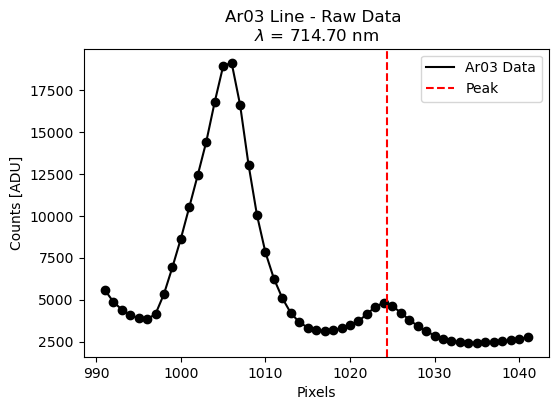

In [5894]:
fig = ar0203.plot_raw_line()

In [5895]:
pixel2wav = interp1d(ar0203.pixel_all, ar0203.wav_all)
pixel_centers = [pAr03, pAr02]

wav_centers = pixel2wav(pixel_centers)
intensitites = np.array([1235, 10500])
weights = intensitites/np.sum(intensitites)

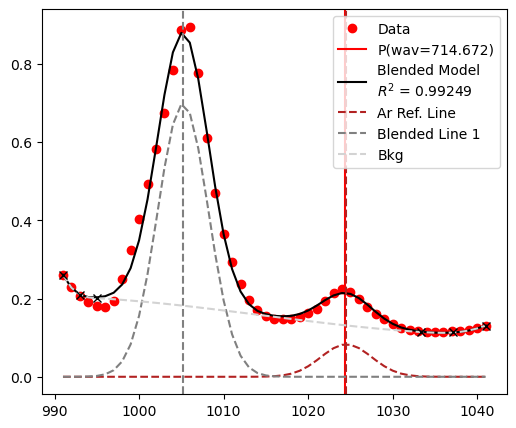

In [5896]:
db = deblendModel(ar0203.pixel, ar0203.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=3.0, nknots=3, npixels=4)
db.plot_fit()

In [5897]:
p2w([db.result.params['peak_center'].value, db.result.params['blend1_center'].value])

array([714.39326751, 706.02335077])

In [5898]:
db.result.params['peak_center'].value

1024.510021434803

## Ar13

In [1341]:
name = "Ar13"
std =1.4
Hg04 = 842.236
llow = Hg04-5*std/2.
lupp = Hg04+5*std/2.

thtml = query_nist("Ar", llow, lupp)
ar11df = parse_nist_html(thtml)
ar11df

,Ion,Observed,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,840.8210,15000,2.23e+07,B+,3s23p5(2P°1/2)4s,3s23p5(2P°1/2)4p,,T5223,L2634
1,Ar I,842.4648,20000,2.15e+07,B+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


In [1342]:
wav_centers = [842.4648, 840.8210]
intensities = [20000, 15000]
weights = intensities/np.sum(intensities)
weights

array([0.57142857, 0.42857143])

In [1353]:
name = "Ar13"
peak = 1330.
exptime = 3

ar11 = Hg2LampLineCharacterization(name, peak, exptime, window=19)

Dark subtraction
Flat fielding


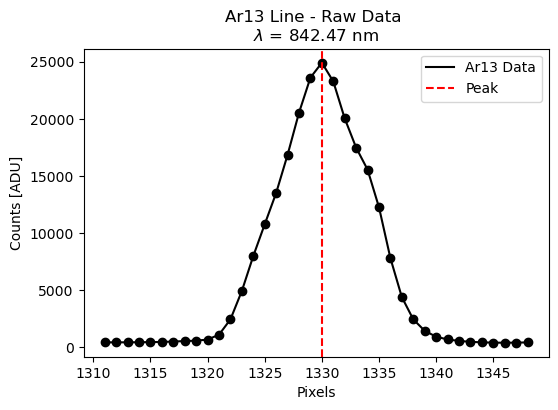

In [1354]:
fig = ar11.plot_raw_line()

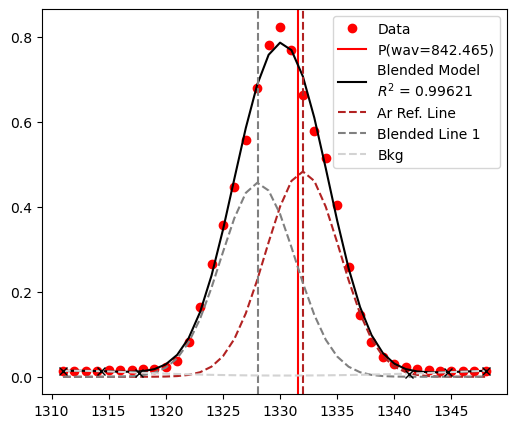

In [1355]:
db = deblendModel(ar11.pixel, ar11.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=3., nknots=3)
db.plot_fit()

In [1356]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(1331.9978349101002, 0.4588086137365201)

## Ar11

In [5929]:
name = "Ar11"
std =1.4
Hg04 = 811.531
llow = Hg04-5*std/2.
lupp = Hg04+5*std/2.

thtml = query_nist("Ar", llow, lupp)
ar11df = parse_nist_html(thtml)
ar11df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,810.3693,,20000,2.50e+07,B+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634
1,Ar II,810.36931,0.00002,"12023r,bl",,,3s23p4(3P)3d,3s23p4(3P)4p,,,L11520
2,Ar I,811.5311,,35000,3.3e+07,B,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


In [5900]:
wav_centers = [811.5311, 810.3693]
intensities = [35000, 20000]
weights = intensities/np.sum(intensities)
weights

array([0.63636364, 0.36363636])

In [5901]:
name = "Ar11"
peak = 1254.0
exptime = 2

ar11 = Hg2LampLineCharacterization(name, peak, exptime, window=16)

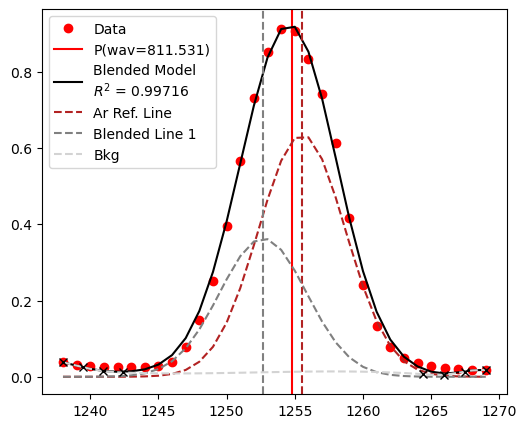

In [5902]:
db = deblendModel(ar11.pixel, ar11.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=3., nknots=4)
db.plot_fit()

In [5903]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(1255.5249503119471, 0.07840408765929084)

## Ar08

In [1082]:
name = "Ar08"
std =1.4
Hg04 = 772.37610
llow = Hg04-5*std/2.
lupp = Hg04+5*std/2.

thtml = query_nist("Ar", llow, lupp)
ar11df = parse_nist_html(thtml)
ar11df

,Ion,Observed,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,772.3761,15000,5.2e+06,B+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634
1,Ar I,772.4207,10000,1.17e+07,B+,3s23p5(2P°1/2)4s,3s23p5(2P°1/2)4p,,T5223,L2634


In [1083]:
wav_centers = [772.3761]
intensities = [15000]
weights = intensities/np.sum(intensities)
weights

array([1.])

In [1084]:
name = "Ar08"
peak = 1161.0
exptime = 2

ar11 = Hg2LampLineCharacterization(name, peak, exptime, window=16)

Dark subtraction
Flat fielding


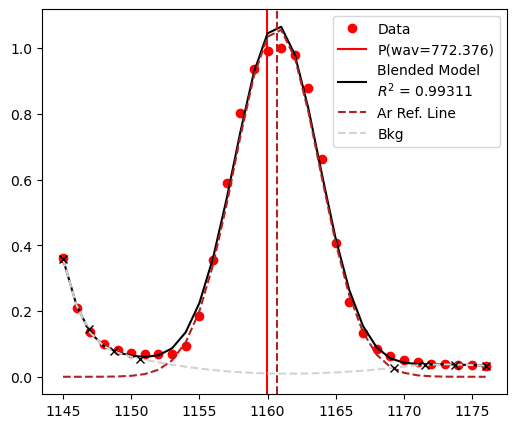

In [5947]:
db = deblendModel(ar11.pixel, ar11.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=3., nknots=4)
db.plot_fit()

In [5949]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(1160.6927720816698, 0.10334597955996348)

In [5950]:
1160.713278

1160.713278

## Hg04

In [1284]:
name = "Hg04"
std =1.4
Hg04 = 313.155
llow = Hg04-5*std/2.
lupp = Hg04+5*std/2.

thtml = query_nist("Hg", llow, lupp)
ar11df = parse_nist_html(thtml)
ar11df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg II,311.6195,0.0004,15000,8.8e+06,,5d107s,5d108p,,T7226,L11760
1,Hg I,312.5674,0.0001,4000,6.6e+07,B+,5d106s6p,5d106s6d,,T5292,L7247
2,Hg I,313.1555,0.0001,3000,,,5d106s6p,5d106s6d,,,L7247
3,Hg I,313.1844,0.0001,4000,,,5d106s6p,5d106s6d,,,L7247


In [1290]:
wav_centers = [313.155, 313.1844, 312.5674]
intensities = [3000, 4000, 4000]
weights = intensities/np.sum(intensities)
weights

array([0.27272727, 0.36363636, 0.36363636])

Dark subtraction
Flat fielding


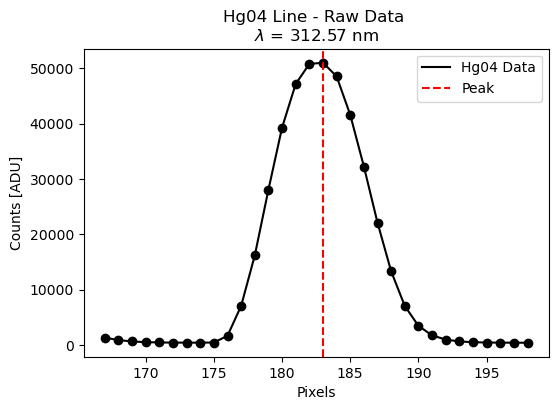

In [1302]:
name = "Hg04"
peak = 183
exptime = 22

ar11 = Hg2LampLineCharacterization(name, peak, exptime, window=16)
fig = ar11.plot_raw_line()

Re-running fit to compute error bars...


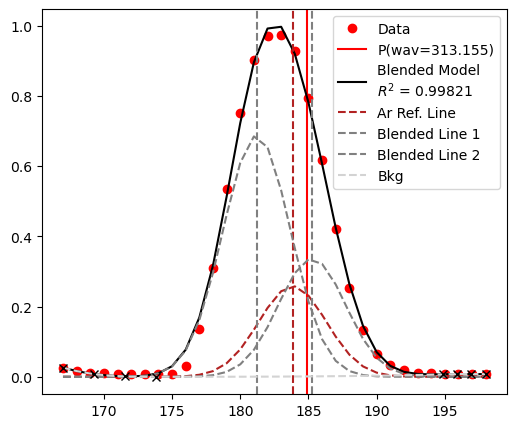

In [1305]:
db = deblendModel(ar11.pixel, ar11.counts, wav_centers, calibration=popt, weights=weights)
db.fit(nsigma=4., nknots=4)
db.plot_fit()

In [1306]:
(db.result.params['peak_center'].value, db.result.params['peak_center'].stderr)

(183.837749249316, 24.761611292505094)

In [524]:
mylinesIntensity = {
                    "365.0158": 9000,
                    "365.4842": 3000,
                    "366.3284": 2000,
                   }

def create_fake_hg2_spectrum(
    wavemin=359.0, 
    wavemax=372.0, 
    npoints=10000, 
    std_nm=1.5, 
    noise_std=10.0
):
    # 1. Create the wavelength array
    wavelengths = np.linspace(wavemin, wavemax, npoints)
    intensities = np.zeros_like(wavelengths)

    # Now add Gaussian peaks for each line:
    gaussians = []
    for line_label, amplitude in mylinesIntensity.items():
        # Get the wavelength center from the parallel dictionary
        line_center = float(line_label)  # in nm

        # Create a Gaussian profile
        # Gauss = amplitude * exp( - (x - center)^2 / (2 * sigma^2) )
        gauss = amplitude * np.exp(
            -0.5 * ((wavelengths - line_center) / std_nm)**2
        )
        intensities+=gauss
        gaussians.append(gauss)

    # 3. Add random noise (baseline)
    #    We'll add a baseline offset of 0 plus some random normal noise with std = noise_std
    noise = np.random.normal(loc=0.0, scale=noise_std, size=len(wavelengths))
    intensities += noise

    # Ensure no negative intensities if that matters
    intensities = np.clip(intensities, 0, None)

    return wavelengths, intensities, gaussians

import numpy as np
from scipy.optimize import fminbound

def gaussian(x, mu, A, sigma):
    """Single Gaussian function."""
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def sum_gaussians(x, means, amplitudes, sigma):
    """Sum of multiple Gaussians."""
    return sum(gaussian(x, mu, A, sigma) for mu, A in zip(means, amplitudes))

def find_max_two_gaussians(means, amplitudes, sigma):
    """Find the approximate max position and value of the sum of two Gaussians."""
    x_approx = (amplitudes[0] * means[0] * np.exp(-((means[0] - means[1]) ** 2) / (2 * sigma ** 2)) +
                amplitudes[1] * means[1]) / \
               (amplitudes[0] * np.exp(-((means[0] - means[1]) ** 2) / (2 * sigma ** 2)) + amplitudes[1])

    # Refine numerically in the range [min(mu) - 2σ, max(mu) + 2σ]
    x_opt = fminbound(lambda x: -sum_gaussians(x, means, amplitudes, sigma),
                      min(means) - 2 * sigma, max(means) + 2 * sigma)

    return x_opt, sum_gaussians(x_opt, means, amplitudes, sigma)

def find_max_three_gaussians(means, amplitudes, sigma):
    """Find the approximate max position and value of the sum of three Gaussians."""
    weights = [A * np.exp(-((mu - np.mean(means)) ** 2) / (2 * sigma ** 2)) for A, mu in zip(amplitudes, means)]
    x_approx = sum(w * mu for w, mu in zip(weights, means)) / sum(weights)

    print(min(means) - 2 * sigma, max(means) + 2 * sigma)
    # Refine numerically in the range [min(mu) - 2σ, max(mu) + 2σ]
    x_opt = fminbound(lambda x: -sum_gaussians(x, means, amplitudes, sigma),
                      np.min(means) - 3 * sigma, np.max(means) + 3 * sigma)
    return x_opt, sum_gaussians(x_opt, means, amplitudes, sigma)


In [525]:
wav, counts, gs = create_fake_hg2_spectrum()

In [527]:
# sig
# means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
# amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
# x_max_3, f_max_3 = find_max_three_gaussians(means_3, amplitudes_3, sigma_3)
# print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")

NameError: name 'x_max_3' is not defined

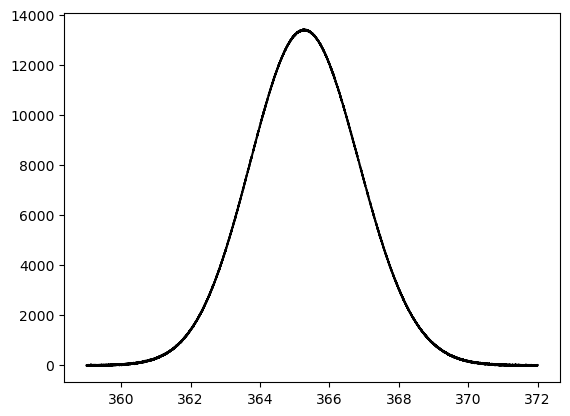

In [528]:
import matplotlib.pyplot as plt
plt.plot(wav, counts, 'k')
plt.vlines(x_max_3,0, np.max(counts), 'k', label='Peak: %.4fnm'%x_max_3)
plt.plot(wav, gs[0], 'r', label='Hg06 Line: 365.0158nm')
plt.vlines(wav[np.argmax(gs[0])],0, np.max(counts), 'r')
plt.plot(wav, gs[1], 'b--')
plt.plot(wav, gs[2], 'g--')
plt.legend()
plt.ylabel('NIST: Rel. Intensity')
plt.xlabel('wavelength [nm]')
plt.title('Outlier Line: Hg06')

In [529]:
wav[np.argmax(counts)]

365.2887288728873

In [530]:
lines = np.array(list(hg2_lines.values()))
names = np.array(list(hg2_lines.keys()))

NameError: name 'hg2_lines' is not defined

In [531]:
names[1+np.where(np.diff(lines)<10)[0]]

NameError: name 'names' is not defined

In [532]:
names[np.where(np.diff(lines)<10)[0]]

NameError: name 'names' is not defined

In [534]:
# m = [0,1,2,5]

## Nist Line By Line

In [535]:
line = 365.0158
sigma = 1.4

llow = line-2*sigma/2.
lupp = line+2*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)

In [536]:
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg I,365.0158,0.0001,9000,1.29e+08,B+,5d106s6p,5d106s6d,,T5292,L7247
1,Hg I,365.4842,0.0001,3000,1.84e+07,B,5d106s6p,5d106s6d,,T5292,L7247
2,Hg I,366.3284,0.0001,2000,,,5d106s6p,5d106s6d,,,L7247


In [537]:
Hg05 = 334.14820
sigma = 1.4

llow = Hg05-3*sigma/2.
lupp = Hg05+3*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)

In [538]:
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg II,333.8424,0.0004,2000c,2.4e+06,,5d96s6p,5d96s7s,,T7226,L11760


In [539]:
Hg01 = 253.65200
sigma = 1.4

llow = Hg01-2*sigma/2.
lupp = Hg01+2*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)

In [3293]:
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg II,252.3324,0.0002,1600p,1.2e+06,,5d96s6p,5d96s7s,,T7226,L11760
1,Hg I,253.4772,0.0002,2000,,,5d106s6p,5d106s7d,,,L3456
2,Hg I,253.6521,0.0001,900000,8.40e+06,A+,5d106s2,5d106s6p,,T7227,L7247
3,Hg II,254.5334,0.0003,1500c,1.8e+06,,5d96s6p,5d96s7s,,T7226,L11760


In [3294]:
Hg02 = 296.72840
sigma = 1.4

llow = Hg02-2*sigma/2.
lupp = Hg02+2*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)

In [3295]:
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg II,295.5125,0.0004,1500,9.5e+06,,5d106d,5d107f,,T7226,L11760
1,Hg I,296.7283,0.0001,3000,4.6e+07,D,5d106s6p,5d106s6d,,T3462,L7247
2,Hg II,297.5118,0.0004,1200h,1.1e+07,,5d96s6p,5d109d,,T7226,L11760


In [3296]:
Hg03 = 302.15060
sigma = 1.4

llow = Hg03-2*sigma/2.
lupp = Hg03+2*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)

In [3297]:
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg I,302.1504,0.0001,1200,5.1e+07,B+,5d106s6p,5d106s7d,,T5292,L7247
1,Hg II,303.4916,0.0004,2000,4.2e+07,,5d107p,5d96s6d,,T7226,L11760


In [3298]:
Hg04 = 313.15560
sigma = 1.4

llow = Hg04-10*sigma/2.
lupp = Hg04+10*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)

In [3299]:
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg II,308.7549,0.0004,1100c,,,,,,,L11760
1,Hg II,311.6195,0.0004,15000,8.8e+06,,5d107s,5d108p,,T7226,L11760
2,Hg I,312.5674,0.0001,4000,6.6e+07,B+,5d106s6p,5d106s6d,,T5292,L7247
3,Hg I,313.1555,0.0001,3000,,,5d106s6p,5d106s6d,,,L7247
4,Hg I,313.1844,0.0001,4000,,,5d106s6p,5d106s6d,,,L7247
5,,,,,,,,,,,
6,Hg II,319.1019,0.0003,7500,1.5e+07,,5d107p,5d109d,,T7226,L11760
7,Hg II,320.1385,0.0003,2500,1.0e+07,,5d107s,5d108p,,T7226,L11760


In [3300]:
mylinesIntensity = {
                    "312.5674": 4000,
                    "313.1555": 3000,
                    "313.1844": 4000,
                   }
wav, counts, gs = create_fake_hg2_spectrum(wavemin=llow, wavemax=lupp, noise_std=1)

In [3301]:
means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
x_max_3, f_max_3 = find_max_three_gaussians(means_3, amplitudes_3, sigma_3)
print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")

310.5674 315.1844
312.9604513445593
Three Gaussians: x_max = 312.960, f_max = 10547.071


Text(0.5, 1.0, 'Outlier Line: Hg06')

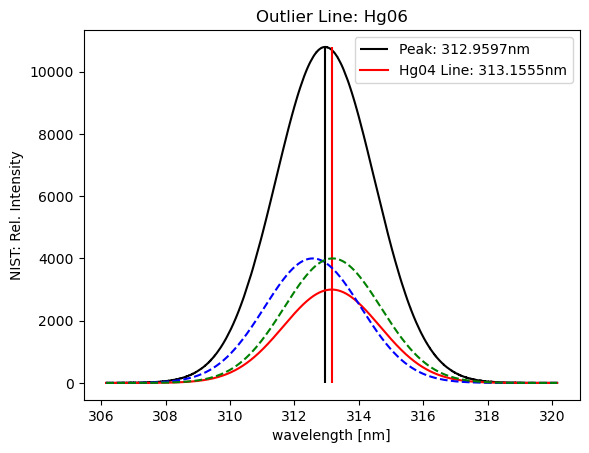

In [3302]:
import matplotlib.pyplot as plt
plt.plot(wav, counts, 'k')
plt.vlines(x_max_3,0, np.max(counts), 'k', label='Peak: %.4fnm'%x_max_3)
plt.plot(wav, gs[1], 'r', label='Hg04 Line: 313.1555nm')
plt.vlines(wav[np.argmax(gs[1])],0, np.max(counts), 'r')
plt.plot(wav, gs[0], 'b--')
plt.plot(wav, gs[2], 'g--')
plt.legend()
plt.ylabel('NIST: Rel. Intensity')
plt.xlabel('wavelength [nm]')
plt.title('Outlier Line: Hg06')

In [3303]:
Hg05 = 334.14820
sigma = 1.4

llow = Hg05-10*sigma/2.
lupp = Hg05+10*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg II,327.7846,0.0004,10000,1.8e+07,,5d96s6p,5d96s7s,,T7226,L11760
1,Hg II,333.8424,0.0004,2000c,2.4e+06,,5d96s6p,5d96s7s,,T7226,L11760
2,Hg II,338.5103,0.0004,2000c,1.5e+07,,5d96s6p,5d96s7s,,T7226,L11760


In [3304]:
Hg05 = 365.01520
sigma = 1.4

llow = Hg05-10*sigma/2.
lupp = Hg05+10*sigma/2.

thtml = query_nist("Hg", llow, lupp)
df = parse_nist_html(thtml)
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Hg II,360.3908,0.0004,1500,2.0e+06,,5d106d,5d106f,,T7226,L11760
1,Hg II,360.4085,0.0004,45000c,1.4e+07,,5d96s6p,5d96s7s,,T7226,L11760
2,Hg II,360.5762,0.0002,100000,3.0e+07,,5d106d,5d106f,,T7226,L11760
3,Hg II,360.6885,0.0004,8000,5.7e+06,,5d107p,5d109d,,T7226,L11760
4,Hg II,363.2363,0.0004,8000,3.5e+06,,5d96s6p,5d96s7s,,T7226,L11760
5,,,,,,,,,,,
6,Hg I,365.0158,0.0001,9000,1.29e+08,B+,5d106s6p,5d106s6d,,T5292,L7247
7,Hg I,365.4842,0.0001,3000,1.84e+07,B,5d106s6p,5d106s6d,,T5292,L7247
8,Hg I,366.3284,0.0001,2000,,,5d106s6p,5d106s6d,,,L7247


In [3305]:
mylinesIntensity = {
                    "365.0158": 9000,
                    "365.4842": 3000,
                    "366.3284": 2000,
                   }
wav, counts, gs = create_fake_hg2_spectrum(wavemin=llow, wavemax=lupp, noise_std=1)

In [3306]:
means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
x_max_3, f_max_3 = find_max_three_gaussians(means_3, amplitudes_3, sigma_3)
print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")

363.0158 368.3284
365.2993472158546
Three Gaussians: x_max = 365.235, f_max = 12794.721


Text(0.5, 1.0, 'Outlier Line: Hg06')

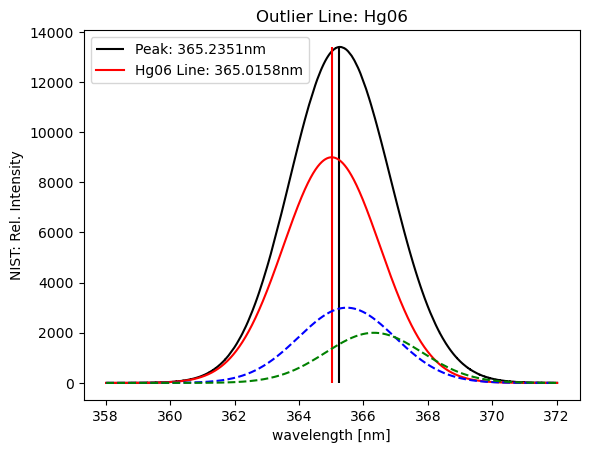

In [3307]:
import matplotlib.pyplot as plt
plt.plot(wav, counts, 'k')
plt.vlines(x_max_3,0, np.max(counts), 'k', label='Peak: %.4fnm'%x_max_3)
plt.plot(wav, gs[0], 'r', label='Hg06 Line: 365.0158nm')
plt.vlines(wav[np.argmax(gs[0])],0, np.max(counts), 'r')
plt.plot(wav, gs[1], 'b--')
plt.plot(wav, gs[2], 'g--')
plt.legend()
plt.ylabel('NIST: Rel. Intensity')
plt.xlabel('wavelength [nm]')
plt.title('Outlier Line: Hg06')

In [3308]:
name = "Ar06"
Ar06 = 750.38690
llow = Ar06-10*sigma/2.
lupp = Ar06+10*sigma/2.

thtml = query_nist("Ar", llow, lupp)
ar06df = parse_nist_html(thtml)
ar06df

,Ion,Observed,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,750.3869,20000,4.5e+07,B,3s23p5(2P°1/2)4s,3s23p5(2P°1/2)4p,,T5223,L2634
1,Ar I,751.4652,15000,4.0e+07,B,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


In [3309]:
mylinesIntensity = {
                    "750.3869": 20000,
                    "751.4652": 15000
                   }
wav, counts, gs = create_fake_hg2_spectrum(wavemin=llow, wavemax=lupp, noise_std=1)

In [3310]:
means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
x_max_3, f_max_3 = find_max_two_gaussians(means_3, amplitudes_3, sigma_3)
print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")

Three Gaussians: x_max = 750.819, f_max = 30390.917


Text(0.5, 1.0, 'Outlier Line: Ar06')

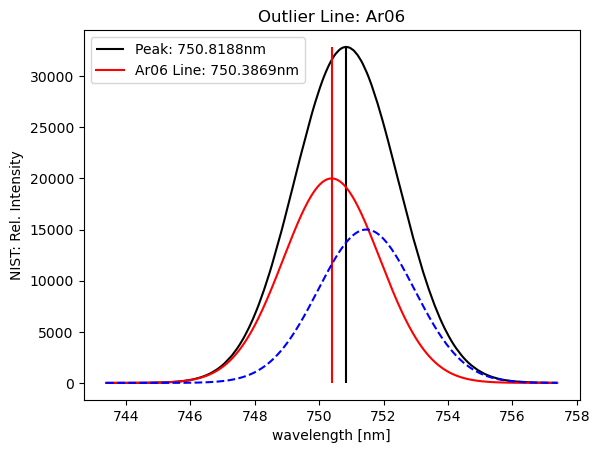

In [3311]:
import matplotlib.pyplot as plt
plt.plot(wav, counts, 'k')
plt.vlines(x_max_3,0, np.max(counts), 'k', label='Peak: %.4fnm'%x_max_3)
plt.plot(wav, gs[0], 'r', label=f'{name} Line: 750.3869nm')
plt.vlines(wav[np.argmax(gs[0])],0, np.max(counts), 'r')
plt.plot(wav, gs[1], 'b--')
# plt.plot(wav, gs[2], 'g--')
plt.legend()
plt.ylabel('NIST: Rel. Intensity')
plt.xlabel('wavelength [nm]')
plt.title(f'Outlier Line: {name}')

In [3312]:
name = "Ar11"
Ar11 = 811.53110
llow = Ar11-10*sigma/2.
lupp = Ar11+10*sigma/2.

thtml = query_nist("Ar", llow, lupp)
df = parse_nist_html(thtml)
df

,Ion,Observed,Unc,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,810.3693,,20000,2.50e+07,B+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634
1,Ar II,810.36931,0.00002,"12023r,bl",,,3s23p4(3P)3d,3s23p4(3P)4p,,,L11520
2,Ar I,811.5311,,35000,3.3e+07,B,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


In [3313]:
mylinesIntensity = {
                    "811.5311": 35000,
                    "810.3693": 20000
                   }
wav, counts, gs = create_fake_hg2_spectrum(wavemin=llow, wavemax=lupp, noise_std=1)

In [3314]:
means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
x_max_3, f_max_3 = find_max_two_gaussians(means_3, amplitudes_3, sigma_3)
print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")

Three Gaussians: x_max = 811.176, f_max = 47306.470


Text(0.5, 1.0, 'Outlier Line: Ar11')

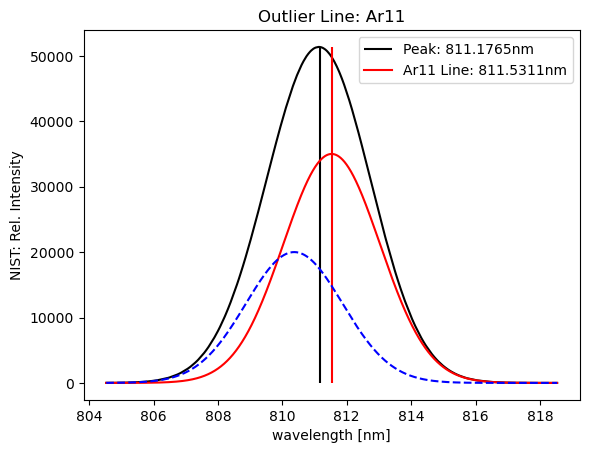

In [3315]:
import matplotlib.pyplot as plt
plt.plot(wav, counts, 'k')
plt.vlines(x_max_3,0, np.max(counts), 'k', label='Peak: %.4fnm'%x_max_3)
plt.plot(wav, gs[0], 'r', label=f'{name} Line: 811.5311nm')
plt.vlines(wav[np.argmax(gs[0])],0, np.max(counts), 'r')
plt.plot(wav, gs[1], 'b--')
# plt.plot(wav, gs[2], 'g--')
plt.legend()
plt.ylabel('NIST: Rel. Intensity')
plt.xlabel('wavelength [nm]')
plt.title(f'Outlier Line: {name}')

In [3316]:
name = "Ar13"
Ar13 = 842.46480
llow = Ar13-10*sigma/2.
lupp = Ar13+10*sigma/2.

thtml = query_nist("Ar", llow, lupp)
df = parse_nist_html(thtml)
df

,Ion,Observed,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,840.8210,15000,2.23e+07,B+,3s23p5(2P°1/2)4s,3s23p5(2P°1/2)4p,,T5223,L2634
1,Ar I,842.4648,20000,2.15e+07,B+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


In [3317]:
mylinesIntensity = {
                    "842.4648": 35000,
                    "840.8210": 15000
                   }
wav, counts, gs = create_fake_hg2_spectrum(wavemin=llow, wavemax=lupp, noise_std=1)

In [3318]:
means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
x_max_3, f_max_3 = find_max_two_gaussians(means_3, amplitudes_3, sigma_3)
print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")

Three Gaussians: x_max = 842.236, f_max = 39607.826


Text(0.5, 1.0, 'Outlier Line: Ar13')

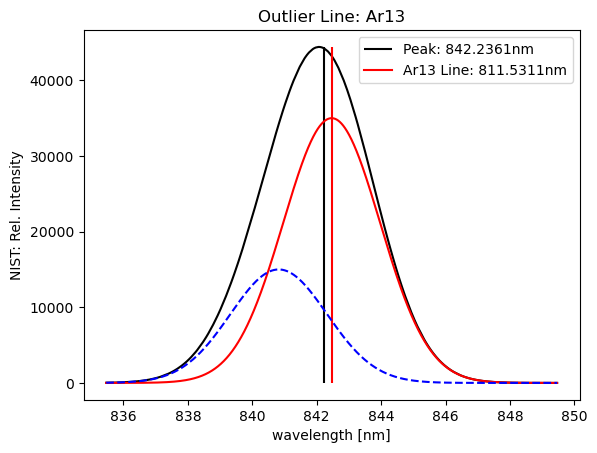

In [3319]:
import matplotlib.pyplot as plt
plt.plot(wav, counts, 'k')
plt.vlines(x_max_3,0, np.max(counts), 'k', label='Peak: %.4fnm'%x_max_3)
plt.plot(wav, gs[0], 'r', label=f'{name} Line: 811.5311nm')
plt.vlines(wav[np.argmax(gs[0])],0, np.max(counts), 'r')
plt.plot(wav, gs[1], 'b--')
# plt.plot(wav, gs[2], 'g--')
plt.legend()
plt.ylabel('NIST: Rel. Intensity')
plt.xlabel('wavelength [nm]')
plt.title(f'Outlier Line: {name}')

In [3320]:
df.loc[df['Ion'] == 'Ar I']

,Ion,Observed,Intensity,Aki,Acc,Lower Level Conf.,Upper Level Conf.,Type,TP Ref,Line Ref
0,Ar I,840.8210,15000,2.23e+07,B+,3s23p5(2P°1/2)4s,3s23p5(2P°1/2)4p,,T5223,L2634
1,Ar I,842.4648,20000,2.15e+07,B+,3s23p5(2P°3/2)4s,3s23p5(2P°3/2)4p,,T5223,L2634


## Find Bad Lines

In [139]:
mylinesIntensity = {
                    "365.0158": 9000,
                    "365.4842": 3000,
                    "366.3284": 2000,
                   }

def create_fake_hg2_spectrum(
    wavemin=359.0, 
    wavemax=372.0, 
    npoints=10000, 
    std_nm=1.5, 
    noise_std=10.0
):
    # 1. Create the wavelength array
    wavelengths = np.linspace(wavemin, wavemax, npoints)
    intensities = np.zeros_like(wavelengths)

    # Now add Gaussian peaks for each line:
    gaussians = []
    for line_label, amplitude in mylinesIntensity.items():
        # Get the wavelength center from the parallel dictionary
        line_center = float(line_label)  # in nm

        # Create a Gaussian profile
        # Gauss = amplitude * exp( - (x - center)^2 / (2 * sigma^2) )
        gauss = amplitude * np.exp(
            -0.5 * ((wavelengths - line_center) / std_nm)**2
        )
        intensities+=gauss
        gaussians.append(gauss)

    # 3. Add random noise (baseline)
    #    We'll add a baseline offset of 0 plus some random normal noise with std = noise_std
    noise = np.random.normal(loc=0.0, scale=noise_std, size=len(wavelengths))
    intensities += noise

    # Ensure no negative intensities if that matters
    intensities = np.clip(intensities, 0, None)

    return wavelengths, intensities, gaussians

import numpy as np
from scipy.optimize import fminbound

def gaussian(x, mu, A, sigma):
    """Single Gaussian function."""
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def sum_gaussians(x, means, amplitudes, sigma):
    """Sum of multiple Gaussians."""
    return sum(gaussian(x, mu, A, sigma) for mu, A in zip(means, amplitudes))

def find_max_two_gaussians(means, amplitudes, sigma):
    """Find the approximate max position and value of the sum of two Gaussians."""
    x_approx = (amplitudes[0] * means[0] * np.exp(-((means[0] - means[1]) ** 2) / (2 * sigma ** 2)) +
                amplitudes[1] * means[1]) / \
               (amplitudes[0] * np.exp(-((means[0] - means[1]) ** 2) / (2 * sigma ** 2)) + amplitudes[1])

    # Refine numerically in the range [min(mu) - 2σ, max(mu) + 2σ]
    x_opt = fminbound(lambda x: -sum_gaussians(x, means, amplitudes, sigma),
                      min(means) - 2 * sigma, max(means) + 2 * sigma)

    return x_opt, sum_gaussians(x_opt, means, amplitudes, sigma)

def find_max_three_gaussians(means, amplitudes, sigma):
    """Find the approximate max position and value of the sum of three Gaussians."""
    weights = [A * np.exp(-((mu - np.mean(means)) ** 2) / (2 * sigma ** 2)) for A, mu in zip(amplitudes, means)]
    x_approx = sum(w * mu for w, mu in zip(weights, means)) / sum(weights)

    print(min(means) - 2 * sigma, max(means) + 2 * sigma)
    # Refine numerically in the range [min(mu) - 2σ, max(mu) + 2σ]
    x_opt = fminbound(lambda x: -sum_gaussians(x, means, amplitudes, sigma),
                      np.min(means) - 3 * sigma, np.max(means) + 3 * sigma)
    return x_opt, sum_gaussians(x_opt, means, amplitudes, sigma)


In [141]:
from pandora.calibration.hg2_lamp import hg2_lines
sigma_3 = 1.4
for line_label, line in hg2_lines.items():
    if 'Ar' in line_label:
        print(line_label, line)
        llow = line-5*sigma/2.
        lupp = line+5*sigma/2.
        
        thtml = query_nist("Ar", llow, lupp)
        df = parse_nist_html(thtml)
        if len(df)>1:
            df = df.loc[df['Ion'] == 'Ar I'].copy()
        if len(df)>1:
            observed = (df['Observed'].values)#.astype(float)
            intensity = (df['Intensity'].values).astype(float)
            print(observed)
            mylinesIntensity = {str(o):int for o, int in zip(observed,intensity)}
            print(df)
            if len(df)==2:
                means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
                amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
                x_max_3, f_max_3 = find_max_two_gaussians(means_3, amplitudes_3, sigma_3)
                print(f"Two Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")
            if len(df)==3:
                means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
                amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
                x_max_3, f_max_3 = find_max_three_gaussians(means_3, amplitudes_3, sigma_3)
                print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")
            print(f"Residuals (newPeak-peak): {x_max_3-line} nm")

        print(10*"---")

Ar04 727.2936
------------------------------
Ar05 738.398
------------------------------
Ar06 750.3869
['750.3869' '751.4652']
    Ion  Observed Intensity      Aki Acc Lower Level Conf.  Upper Level Conf.  \
0  Ar I  750.3869     20000  4.5e+07   B  3s23p5(2P°1/2)4s   3s23p5(2P°1/2)4p   
1  Ar I  751.4652     15000  4.0e+07   B  3s23p5(2P°3/2)4s   3s23p5(2P°3/2)4p   

  Type TP Ref Line Ref  
0       T5223    L2634  
1       T5223    L2634  
Two Gaussians: x_max = 750.836, f_max = 32556.080
Residuals (newPeak-peak): 0.44909420510566633 nm
------------------------------
Ar07 763.511
------------------------------
Ar08 772.376
['772.3761' '772.4207']
    Ion  Observed Intensity       Aki Acc Lower Level Conf.  \
0  Ar I  772.3761     15000   5.2e+06  B+  3s23p5(2P°3/2)4s   
1  Ar I  772.4207     10000  1.17e+07  B+  3s23p5(2P°1/2)4s   

   Upper Level Conf. Type TP Ref Line Ref  
0   3s23p5(2P°3/2)4p       T5223    L2634  
1   3s23p5(2P°1/2)4p       T5223    L2634  
Two Gaussians: x_max 

In [542]:
sigma_3 = 1.4
for line_label, line in hg2_lines.items():
    if 'Hg' in line_label:
        print(line_label, line)
        llow = line-5*sigma/2.
        lupp = line+5*sigma/2.
        
        thtml = query_nist("Hg", llow, lupp)
        df = parse_nist_html(thtml)
        df = df.loc[df['Ion'] == 'Hg I'].copy()
        if len(df)>1:
            observed = (df['Observed'].values)#.astype(float)
            intensity = (df['Intensity'].values).astype(float)
            mylinesIntensity = {str(o):int for o, int in zip(observed,intensity)}
            if len(df)==2:
                means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
                amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
                x_max_3, f_max_3 = find_max_two_gaussians(means_3, amplitudes_3, sigma_3)
                print(f"Two Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")
            if len(df)==3:
                means_3 = np.array(list(mylinesIntensity.keys())).astype(float)
                amplitudes_3 = np.array(list(mylinesIntensity.values())).astype(float)
                x_max_3, f_max_3 = find_max_three_gaussians(means_3, amplitudes_3, sigma_3)
                print(f"Three Gaussians: x_max = {x_max_3:.3f}, f_max = {f_max_3:.3f}")
            print(f"Residuals (newPeak-peak): {x_max_3-line} nm")

        print(10*"---")

Hg01 253.652
Two Gaussians: x_max = 253.652, f_max = 901984.488
Residuals (newPeak-peak): -0.0002847557673248957 nm
------------------------------
Hg02 296.7284
------------------------------
Hg03 302.1506
------------------------------
Hg04 312.5674
309.7674 315.9844
Three Gaussians: x_max = 312.956, f_max = 10765.655
Residuals (newPeak-peak): 0.3884372990268048 nm
------------------------------
Hg05 334.1482
------------------------------
Hg06 365.4842
362.2158 369.1284
Three Gaussians: x_max = 365.268, f_max = 13320.837
Residuals (newPeak-peak): -0.21623566702129438 nm
------------------------------
Hg07 404.6565
Two Gaussians: x_max = 404.679, f_max = 12083.974
Residuals (newPeak-peak): 0.022118992417745176 nm
------------------------------
Hg08 435.8343
------------------------------
Hg09 546.0735
------------------------------
Hg10 576.9598
------------------------------
